## Introduction

This notebook explores a dataset provided by a ride-sharing company seeking to implement a dynamic pricing strategy. Currently, the company sets fares based solely on ride duration. This project aims to leverage data-driven techniques to develop a predictive model for dynamic pricing that adjusts fares in response to real-time market conditions.

The provided dataset encompasses historical ride information, including features like the number of riders, drivers, location categories, customer loyalty, past rides, average ratings, booking time, vehicle type, expected ride duration, and historical costs.

Our objective here is to build a dynamic pricing model that utilizes these features to predict optimal fares for rides in real-time, considering factors like demand patterns and driver availability.

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

## EDA

In [3]:
# Loading data
data = pd.read_csv(r"./dynamic_pricing.csv")
data.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [5]:
data.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In lack of a complete coloumn description we need to make some assumptions. For the further analysis we assume the following: 

Number_of_Riders: The number of riders available at the time of booking, reflecting the market situation.<br>
Number_of_Drivers: The number of drivers available at the time of booking, reflecting the market situation.<br>
Location_Category: The category representing the geographical location where the ride was booked, such as Urban, Suburban, or Rural.<br>
Customer_Loyalty_Status: The loyalty status of the customer towards the ride-sharing company, indicating whether the customer is a regular user or enrolled in a loyalty program.<br>
Number_of_Past_Rides: The number of past rides taken by the customer, indicating their experience and familiarity with the service.<br>
Average_Ratings: The average rating given by the customer for past rides, reflecting customer satisfaction and feedback.<br>
Time_of_Booking: The time of the day when the ride was booked, categorized into different time slots such as Morning, Afternoon, Evening, or Night.<br>
Vehicle_Type: The type of vehicle used for the ride, such as Premium, Economy, or other classes.<br>
Expected_Ride_Duration: The expected duration of the ride in minutes.<br>
Historical_Cost_of_Ride: The historical cost of past rides, indicating pricing patterns and customer spending.<br>

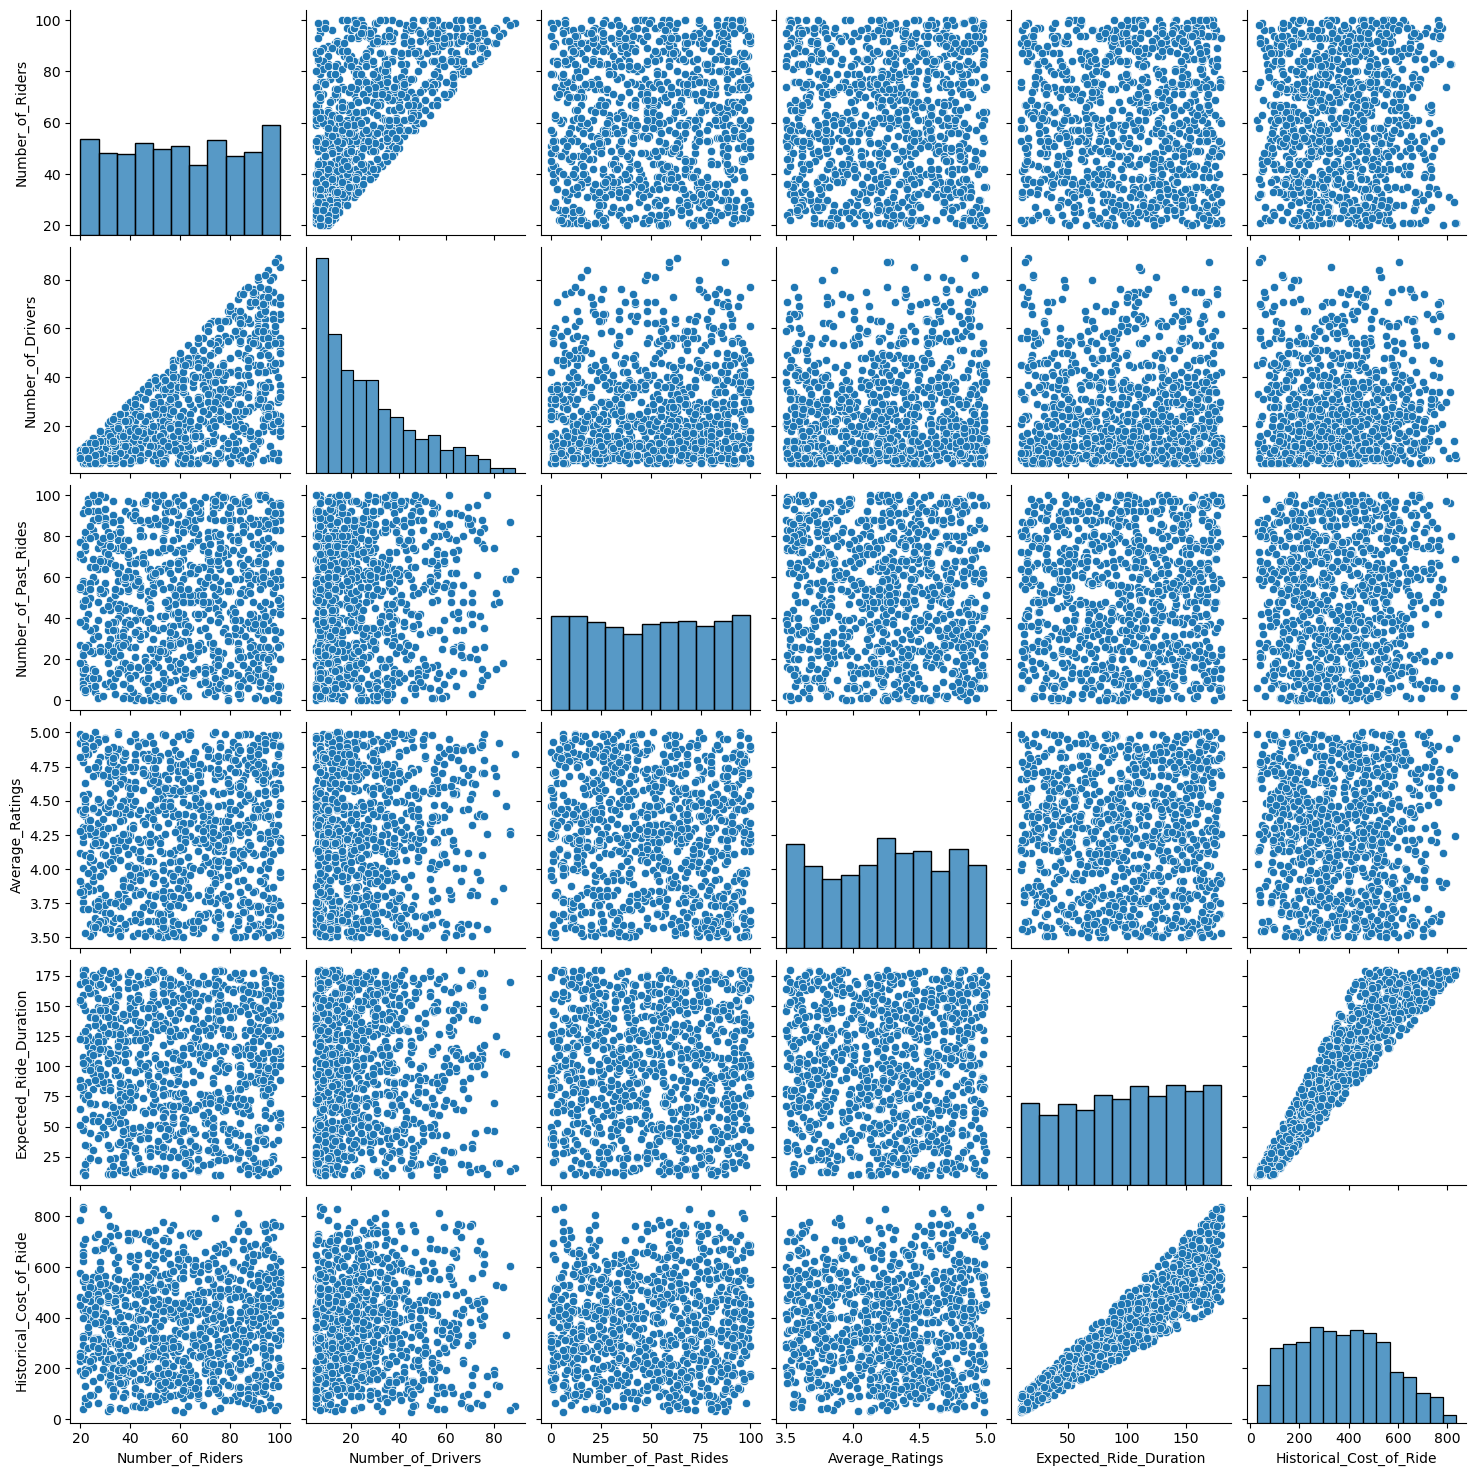

In [6]:
numerical_data = data[['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 
                       'Average_Ratings', 'Expected_Ride_Duration', 'Historical_Cost_of_Ride']]

sns.pairplot(numerical_data, diag_kind='hist')
plt.show()

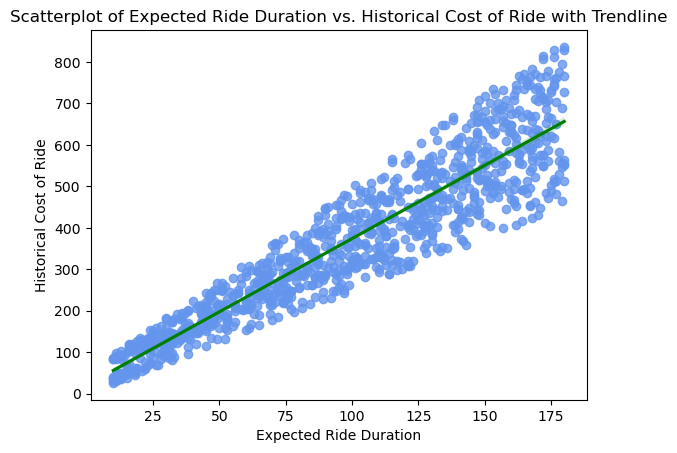

In [7]:
sns.regplot(x='Expected_Ride_Duration', y='Historical_Cost_of_Ride', data=data, 
            scatter=True, color='cornflowerblue', line_kws={"color": "green"})

plt.title('Scatterplot of Expected Ride Duration vs. Historical Cost of Ride with Trendline')
plt.xlabel('Expected Ride Duration')
plt.ylabel('Historical Cost of Ride')
plt.show()

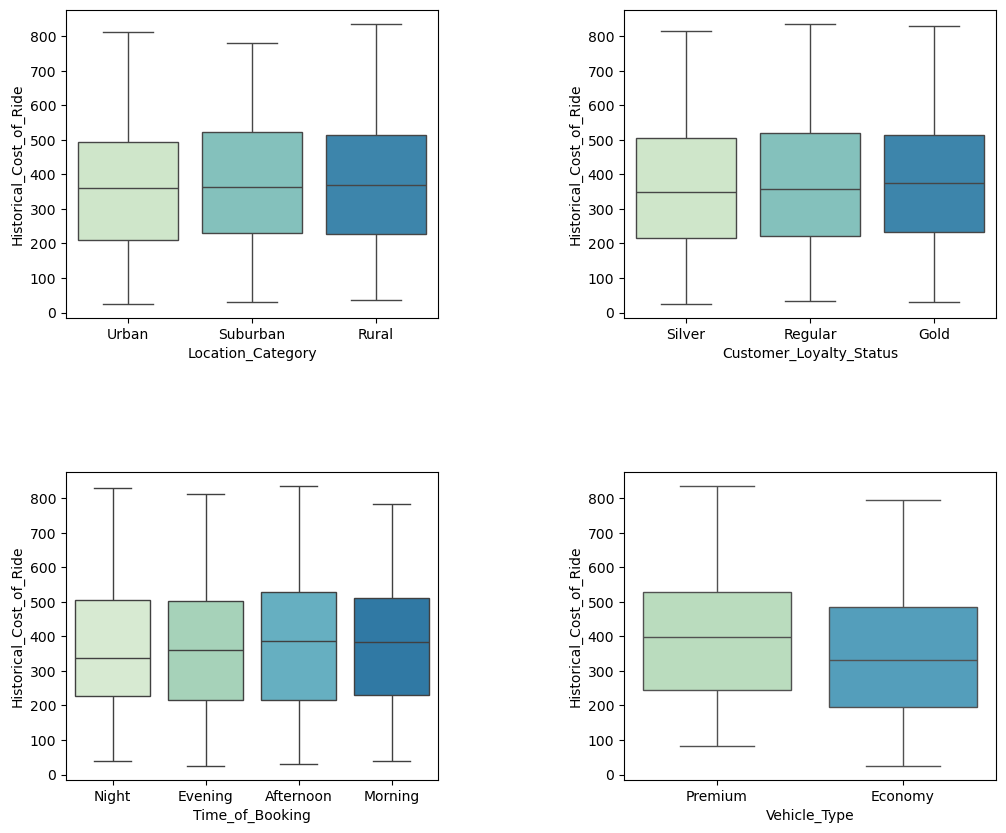

In [8]:
cat = ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type']

# create subplots 
plt.figure(figsize=(12,10))

for i, c in enumerate(cat, 1):
    plt.subplot(2,2,i)
    sns.boxplot(y=data['Historical_Cost_of_Ride'], x=data[c],  palette='GnBu')
    
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()       


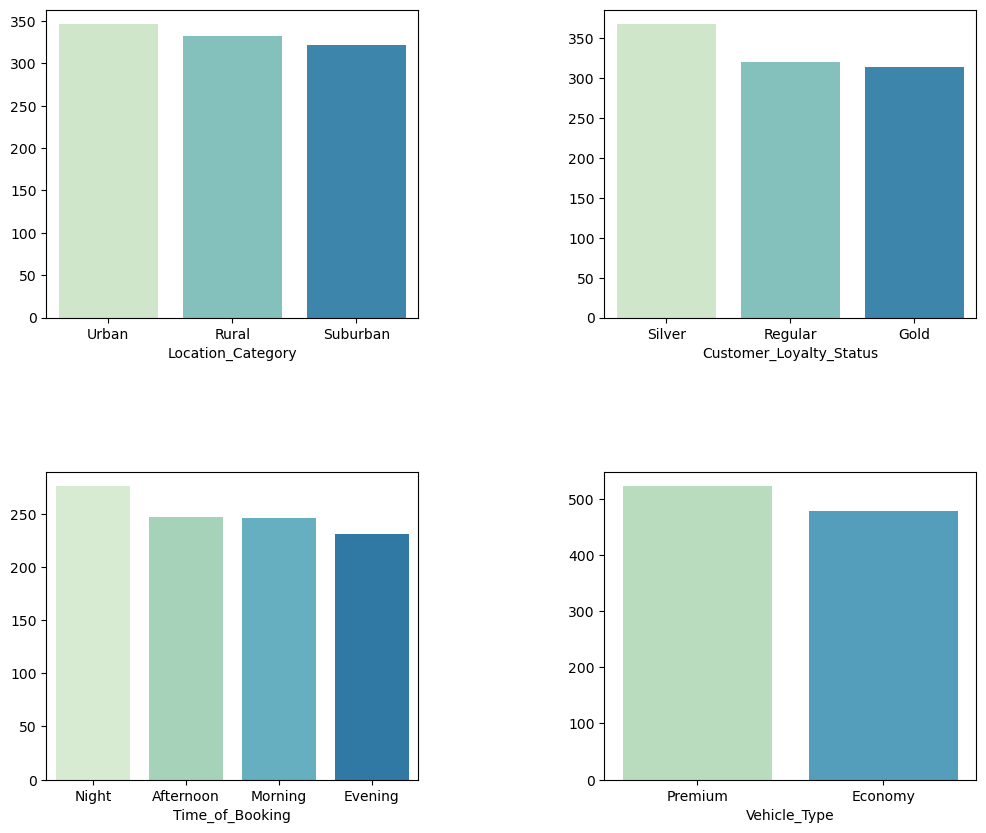

In [9]:
plt.figure(figsize=(12, 10))

for i, c in enumerate(cat, 1):
        plt.subplot(2,2,i)
        c_counts = data[c].value_counts()
        
        sns.barplot(x=c_counts.index, y=c_counts.values, palette='GnBu')
        
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

**A look at the results:**
- Urban rides are the cheapest
- Regular and Gold customer pay surprisingly identical prices
- AFternoon rides tend to be significantly more expensive
- Big Differerence between the vehicle Type 


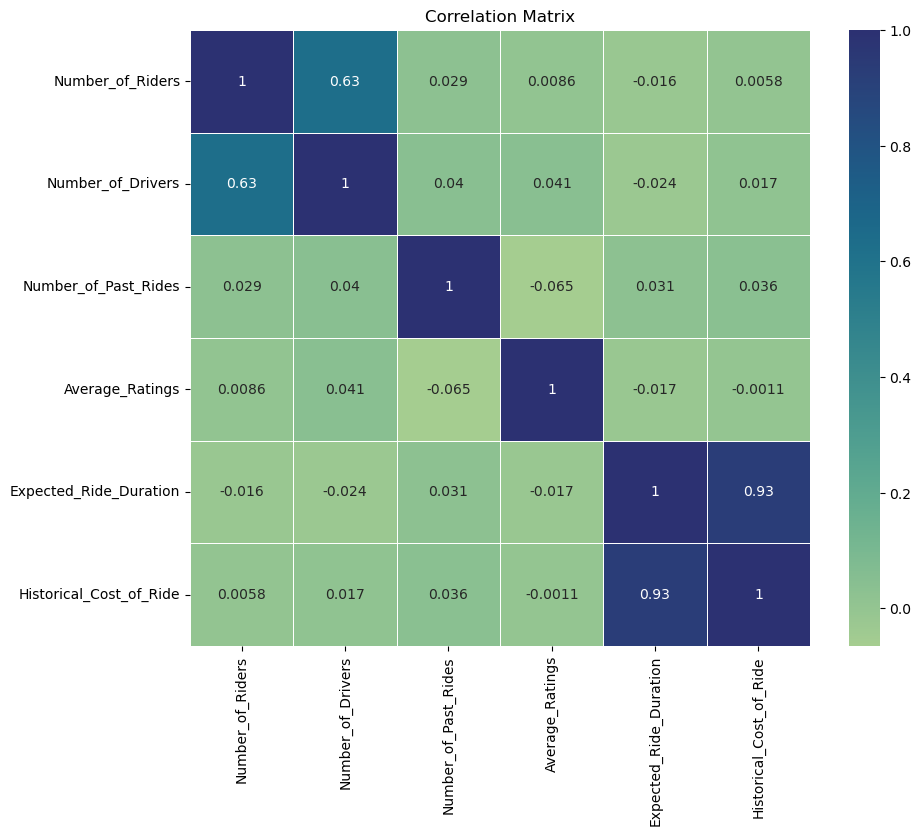

In [10]:
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Preprocessing

In [11]:
data = pd.get_dummies(data, columns= cat, dtype = int)
data.head()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride,Location_Category_Rural,Location_Category_Suburban,Location_Category_Urban,Customer_Loyalty_Status_Gold,Customer_Loyalty_Status_Regular,Customer_Loyalty_Status_Silver,Time_of_Booking_Afternoon,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Vehicle_Type_Economy,Vehicle_Type_Premium
0,90,45,13,4.47,90,284.257273,0,0,1,0,0,1,0,0,0,1,0,1
1,58,39,72,4.06,43,173.874753,0,1,0,0,0,1,0,1,0,0,1,0
2,42,31,0,3.99,76,329.795469,1,0,0,0,0,1,1,0,0,0,0,1
3,89,28,67,4.31,134,470.201232,1,0,0,0,1,0,1,0,0,0,0,1
4,78,22,74,3.77,149,579.681422,1,0,0,0,1,0,1,0,0,0,1,0


In [12]:
X = data.drop('Historical_Cost_of_Ride', axis = 1)
y = data['Historical_Cost_of_Ride']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans

from sklearn.metrics import r2_score, mean_squared_error

## Modeling

Upon completing exploratory data analysis (EDA) and gaining insights into the dataset, the next step is to develop predictive models for price estimation. In this phase, we will explore the performance of various machine learning algorithms, namely K-Nearest Neighbors, Random Forest, Linear Regression, and Gradient Boosting, in predicting prices based on the available features. Through rigorous evaluation, we aim to identify the most effective model for accurate price prediction, thereby facilitating informed decision-making and enhancing the overall efficiency of our system.

In [15]:
# Creating a dictionary to store the results
results = {}

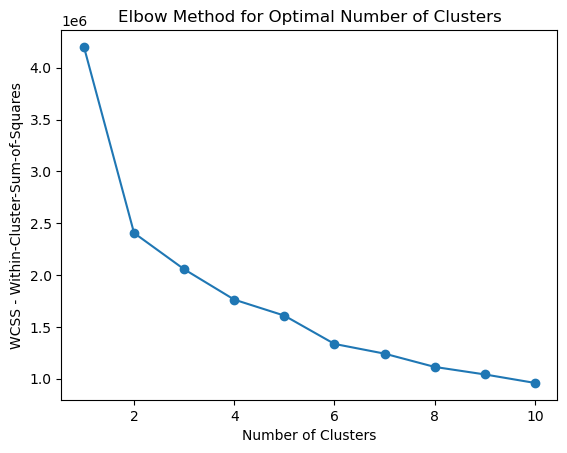

In [16]:
# In this section, we'll use the Elbow Method to determine the optimal number of clusters for the K-Nearest Neighbor algorithm.
from sklearn.cluster import KMeans

wcss = []
max_cluster = 10

for c in range(1, max_cluster+1):
    kmeans = KMeans(n_clusters=c, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, max_cluster+1), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS - Within-Cluster-Sum-of-Squares')
plt.show()

In [17]:
# Linear regression specifically targeting features that exhibit linear relationships, as observed during the EDA phase.
lr = LinearRegression()
lr.fit(X_train[['Expected_Ride_Duration']], y_train)
y_pred_lr = lr.predict(X_test[['Expected_Ride_Duration']])

RMSE = mean_squared_error(y_test, y_pred_lr, squared=False)
r2 = r2_score(y_test, y_pred_lr)

results['Lineare Regression'] = {'RMSE': RMSE.round(3), 'r2': r2.round(3)}

In this phase, we assess the performance of several machine learning models in predicting prices based on the available features. The models under consideration include K-Nearest Neighbor, Random Forest, and Gradient Boosting algorithms.

In [18]:
models = {
    "K-Nearest-Neighbor": KMeans(n_clusters = 2),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=3)}

#results = {}
    
for name, model in models.items():
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    r2 = r2_score(y_test, prediction)
    RMSE = mean_squared_error(y_test, prediction, squared=False)
    results[name] = {'RMSE': RMSE.round(3), 'r2': r2.round(3)}

In [19]:
df_result = pd.DataFrame(results)
df_result

,Lineare Regression,K-Nearest-Neighbor,Random Forest,Gradient Boosting
RMSE,73.508,425.452,73.949,72.615
r2,0.847,-4.131,0.845,0.851


Upon evaluating the machine learning models for price prediction, the following observations were made:

*Linear Regression:*
Linear Regression demonstrates reasonable performance, as evidenced by an RMSE of 73.508 and an R² of 0.847. These metrics indicate that the model effectively explains a substantial amount of variance in the data, suggesting its suitability for this predictive task.

*K-Nearest Neighbor:*
In contrast, K-Nearest Neighbor exhibits poor performance relative to other models. It yields a considerably high RMSE of 425.927 and a negative R² value, indicating that it fails to accurately capture the underlying patterns in the data. Thus, K-Nearest Neighbor is not deemed suitable for the task of price prediction in this context.

*Random Forest and Gradient Boosting:*
Both Random Forest and Gradient Boosting models perform comparably well, with RMSE values hovering around 74 and R² scores ranging between 0.84 and 0.85. These models effectively capture the underlying patterns in the data, demonstrating their potential for accurate price prediction. 

## Hyperparameter Tuning

In this section, we will use grid search with cross-validation to tune the hyperparameters of our models. By systematically exploring different combinations of hyperparameters, we aim to find the optimal settings that maximize the model's performance on the validation data.

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
results_tuned = {}

In [22]:
# Random Forest


param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor()
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
print("Best Hyperparameters for Random Forest:", best_params_rf)

Best Hyperparameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
# Gradient Boosting

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

gb = GradientBoostingRegressor()
grid_search_gb = GridSearchCV(gb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)

best_params_gb = grid_search_gb.best_params_
print("Best Hyperparameters for Gradient Boosting:", best_params_gb)

**Model Training with Optimized Hyperparameters**

Having tuned the hyperparameters of our base models and excluded the K-Nearest Neighbor model due to poor performance, we now proceed to train the remaining models using the optimized parameters. This will allow us to build a meta-model for dynamic pricing prediction based on the insights gained from the tuning process.

In [ ]:
results_tuned = {}

In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train[['Expected_Ride_Duration']], y_train)
y_pred_lr = lr.predict(X_test[['Expected_Ride_Duration']])

RMSE = mean_squared_error(y_test, y_pred_lr, squared=False)
r2 = r2_score(y_test, y_pred_lr)

results_tuned['Lineare Regression'] = {'RMSE': RMSE.round(3), 'r2': r2.round(3)}

# Random Forest and Gradient Boosting
models = {
    "Random Forest": RandomForestRegressor(**best_params_rf),
    "Gradient Boosting": GradientBoostingRegressor(**best_params_gb)}

    
for name, model in models.items():
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    r2 = r2_score(y_test, prediction)
    RMSE = mean_squared_error(y_test, prediction, squared=False)
    results_tuned[name] = {'RMSE': RMSE.round(3), 'r2': r2.round(3)}

In [ ]:
df_result_tuned = pd.DataFrame(results_tuned)
print(df_result_tuned)

      Lineare Regression  Random Forest  Gradient Boosting
RMSE              73.508         74.765             71.186
r2                 0.847          0.842              0.856


In [ ]:
df_diff = df_result - df_result_tuned
df_diff

,Gradient Boosting,K-Nearest-Neighbor,Lineare Regression,Random Forest
RMSE,1.451,NaN,0.0,0.249
r2,-0.006,NaN,0.0,-0.002


In [ ]:
relative_change_df = ((df_diff/ df_result) * 100).round(2)
relative_change_df

,Gradient Boosting,K-Nearest-Neighbor,Lineare Regression,Random Forest
RMSE,2.00,NaN,0.0,0.33
r2,-0.71,NaN,0.0,-0.24


## Meta Model

Now that we have identified the best performing models (Gradient Boosting, Linear Regression, and Random Forest), we proceed to construct our meta model. In this phase, we will utilize the predictions generated by these base models to train a meta model, aiming to further enhance predictive accuracy and capture underlying patterns effectively. 


In [ ]:
# Predictions from base models on the training data
lr_pred_train = lr.predict(X_train[["Expected_Ride_Duration"]])
rf_pred_train = models["Random Forest"].predict(X_train)
gb_pred_train = models["Gradient Boosting"].predict(X_train)

# Predictions from base models on the test data
lr_pred_test = lr.predict(X_test[["Expected_Ride_Duration"]])
rf_pred_test = models["Random Forest"].predict(X_test)
gb_pred_test = models["Gradient Boosting"].predict(X_test)

X_train_stacked = np.column_stack((lr_pred_train, rf_pred_train, gb_pred_train))
X_test_stacked = np.column_stack((lr_pred_test, rf_pred_test, gb_pred_test))

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()}

meta_results = {}
    
for name, model in models.items():
    model.fit(X_train_stacked, y_train)
    prediction = model.predict(X_test_stacked)
    r2 = r2_score(y_test, prediction)
    RMSE = mean_squared_error(y_test, prediction, squared=False)
    meta_results[name] = {'RMSE': RMSE.round(3), 'r2': r2.round(3)}

In [ ]:
df_meta_results = pd.DataFrame(meta_results)
df_meta_results

,Linear Regression,Random Forest,Gradient Boosting
RMSE,80.979,81.070,79.008
r2,0.814,0.814,0.823


In conclusion, after comparing the performance of Linear Regression, Random Forest, and Gradient Boosting models for the stacked ensemble, we have determined that Gradient Boosting exhibits the most promising results in terms of both RMSE and R². With its superior performance, Gradient Boosting is selected as the preferred model for the stacked ensemble. This choice is supported by its ability to effectively utilize predictions from base models and its capacity to generalize well to unseen data, making it an optimal candidate for further tuning and deployment in the dynamic pricing strategy implementation.

In [ ]:
# Meta Gradient Boosting

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

gbm = GradientBoostingRegressor()
grid_search_gbm = GridSearchCV(gb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_gbm.fit(X_train_stacked, y_train)

best_params_gbm = grid_search_gbm.best_params_
print("Best Hyperparameters for Gradient Boosting:", best_params_gbm)

Best Hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
best_gbm_meta = GradientBoostingRegressor(**best_params_gbm)
best_gbm_meta.fit(X_train_stacked, y_train)

y_pred_meta = best_gbm_meta.predict(X_test_stacked)
RMSE_meta = mean_squared_error(y_test, y_pred_meta, squared=False)
r2_meta = r2_score(y_test, y_pred_meta)

print("Meta-Model Performance:")
print("RMSE:", RMSE_meta.round(3))
print("R²:", r2_meta.round(3))

Meta-Model Performance:
RMSE: 80.644
R²: 0.816



# Summary:

We have developed a dynamic pricing model for a ride-sharing company by leveraging data-driven techniques. The model incorporates various features such as the number of riders, number of drivers, location category, customer loyalty status, and more to predict optimal fares for rides in real-time. We followed these key steps in the development process:

***Data Preprocessing and Exploration:***
Handled missing values, encoded categorical variables, and scaled numerical features.
Explored correlations between features and the target variable.

***Model Training and Evaluation:***
Trained base models including Linear Regression, Random Forest, and Gradient Boosting.
Tuned hyperparameters for base models to optimize predictive performance.
Evaluated models using metrics like RMSE and R² on test data.

***Meta-Model Development:***
Created a meta-model by stacking predictions from base models.
Tuned hyperparameters for the meta-model to improve overall performance.
Trained the meta-model and evaluated its performance on the test set.

# Next Steps for the Company:

***Deployment:***
Deploy the trained meta-model into a real-time system where it can receive input data (ride characteristics) and produce dynamic fare predictions.
Ensure the model can handle real-time updates and adapt to changing market conditions.

***Monitoring and Maintenance:***
Continuously monitor the performance of the deployed model in production to detect any degradation or drift.
Retrain the model periodically using new data to maintain its accuracy and relevance.

***Further Analysis and Improvement:***
Conduct additional analysis to identify any potential areas for improvement in the model.
Explore new features or data sources that could enhance the predictive power of the model.